In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models


In [16]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Définir le chemin du dataset
data_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"
# Définir le répertoire de travail où nous allons créer les ensembles train/test
work_dir = "/kaggle/working/"
train_dir = os.path.join(work_dir, 'train')
test_dir = os.path.join(work_dir, 'test')

# Définir les classes
classes = ["lung_aca", "lung_n", "lung_scc"]

# Créer les dossiers pour train et test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)

    # Diviser les images en ensembles d'entraînement et de test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Créer les répertoires pour chaque classe
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copier les images dans les répertoires correspondants
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, cls, img))

    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, cls, img))

print("Les ensembles d'entraînement et de test ont été créés avec succès.")


Les ensembles d'entraînement et de test ont été créés avec succès.


In [17]:
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"


In [18]:
# Function to visualize a few images from each class
def visualize_data_classes(train_dir, num_images=5):
    classes = os.listdir(train_dir)
    plt.figure(figsize=(15, 10))

    for cls in classes:
        class_dir = os.path.join(train_dir, cls)
        images = os.listdir(class_dir)[:num_images]  # Get a few images from each class
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(classes), num_images, i + 1 + classes.index(cls) * num_images)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    plt.show()

# Function to count images per class
def count_images_per_class(train_dir):
    classes = os.listdir(train_dir)
    class_counts = {}
    
    for cls in classes:
        class_dir = os.path.join(train_dir, cls)
        class_counts[cls] = len(os.listdir(class_dir))  # Count images in each class

    return class_counts

# Function to check the sizes of images in the dataset
def check_image_sizes(train_dir):
    sizes = []
    classes = os.listdir(train_dir)

    for cls in classes:
        class_dir = os.path.join(train_dir, cls)
        images = os.listdir(class_dir)
        
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            sizes.append(img.shape[:2])  # Store height and width of the image

    return sizes

# Function to create the ImageDataGenerator
def create_data_generators(train_dir, image_size=(128, 128), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,  # Normalize the images
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,  # Resize images to this size
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return train_generator

# Function to check image size and shape
def check_image_shape(generator):
    for images, labels in generator:
        print("Image shape:", images.shape)  # Print shape of the images in the batch
        print("Label shape:", labels.shape)  # Print shape of the labels in the batch
        break  # Only check the shape of the first batch


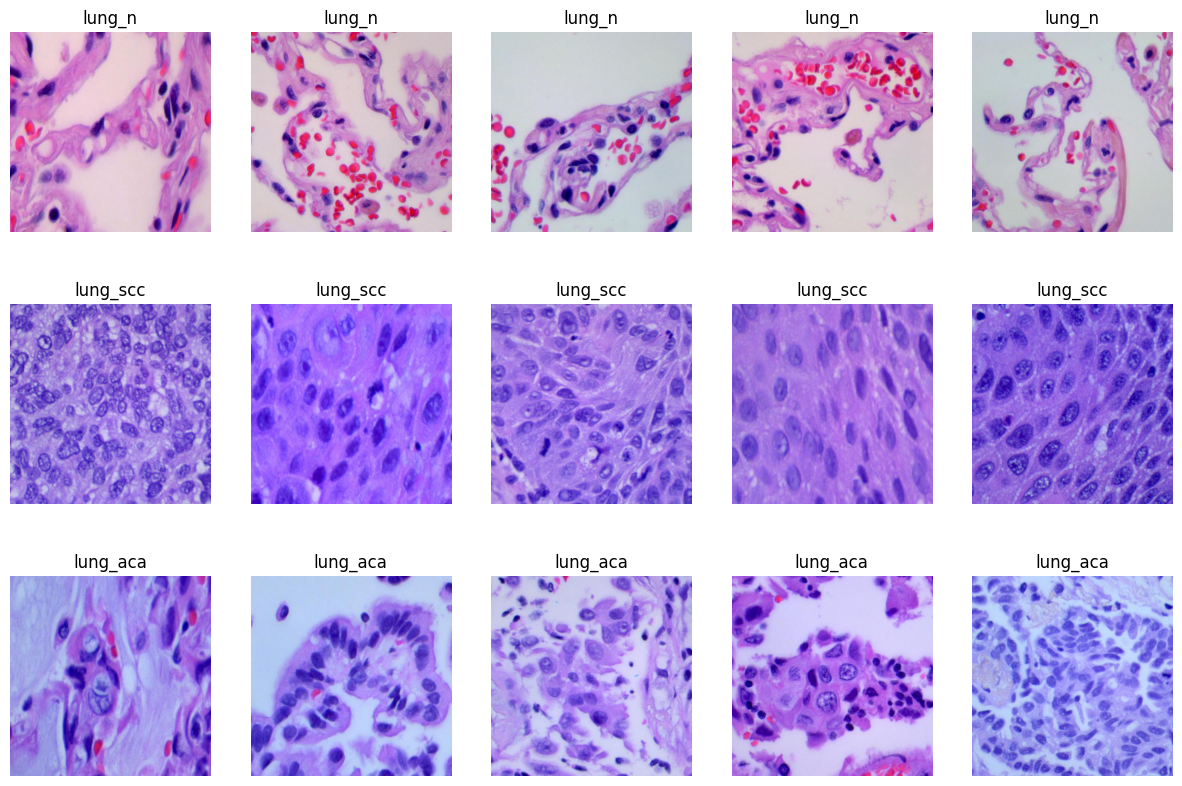

Number of images per class: {'lung_n': 4000, 'lung_scc': 4000, 'lung_aca': 4000}


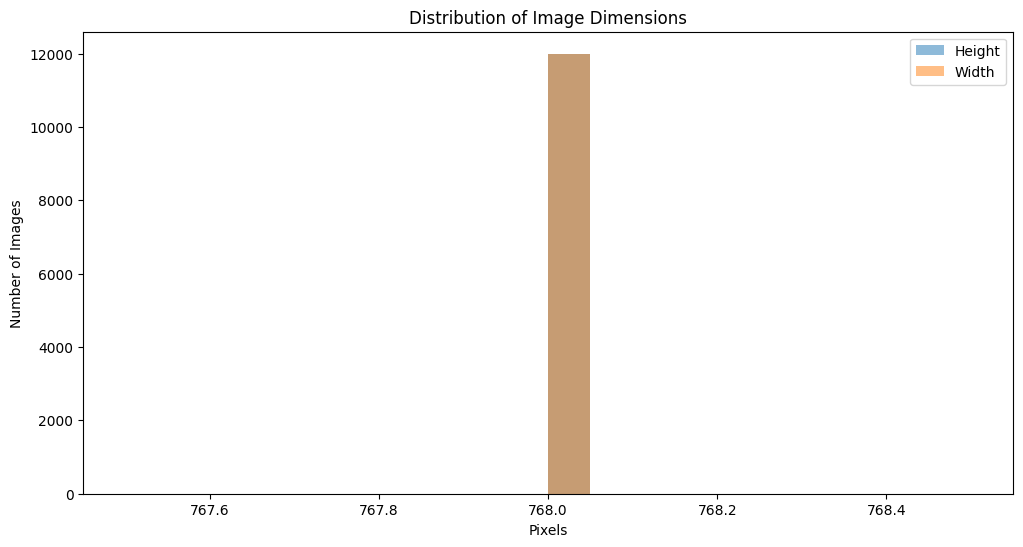

Found 12000 images belonging to 3 classes.
Batch shape: (32, 128, 128, 3)
Labels shape: (32, 3)


In [19]:
# Define the training directory
train_dir = "/kaggle/working/train"  # Update with your train directory path

# Visualize images from each class
visualize_data_classes(train_dir, num_images=5)

# Count images per class
class_counts = count_images_per_class(train_dir)
print("Number of images per class:", class_counts)

# Check sizes of images in the training set
image_sizes = check_image_sizes(train_dir)

# Display a histogram of image dimensions
heights, widths = zip(*image_sizes)
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.title('Distribution of Image Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Number of Images')
plt.legend()
plt.show()

# Create data generator
train_generator = create_data_generators(train_dir, image_size=(128, 128), batch_size=32)

# Check the shape of the images from the generator
for X_batch, y_batch in train_generator:
    print("Batch shape:", X_batch.shape)  # Should be (batch_size, 128, 128, 3)
    print("Labels shape:", y_batch.shape)  # Should be (batch_size, num_classes)
    break  # Stop after the first batch



In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_cnn_model(input_shape=(128, 128, 3), num_classes=3):
    model = Sequential()
    
    # Input Layer
    model.add(Input(shape=input_shape))
    
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening Layer
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model

# Create the model
model = create_cnn_model()
model.summary()  # Display the model architecture
    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.7065 - loss: 0.6297 - val_accuracy: 0.8679 - val_loss: 0.3071
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.8725 - loss: 0.3289 - val_accuracy: 0.8942 - val_loss: 0.2400
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.8949 - loss: 0.2772 - val_accuracy: 0.9087 - val_loss: 0.2133
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9074 - loss: 0.2367 - val_accuracy: 0.9221 - val_loss: 0.2029
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.9234 - loss: 0.1924 - val_accuracy: 0.9262 - val_loss: 0.1777
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9325 - loss: 0.1790 - val_accuracy: 0.9237 - val_loss: 0.1909
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9402 - loss: 0.1458 - val_accuracy: 0.9171 - val_loss: 0.2155
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9318 - loss: 0.1674 - val

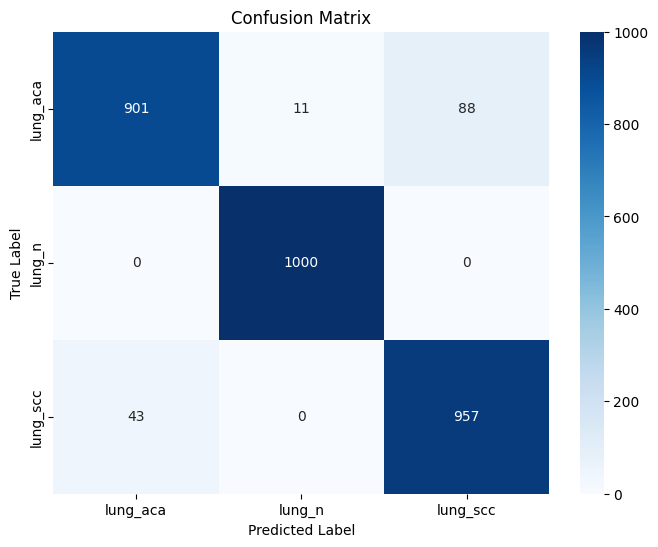

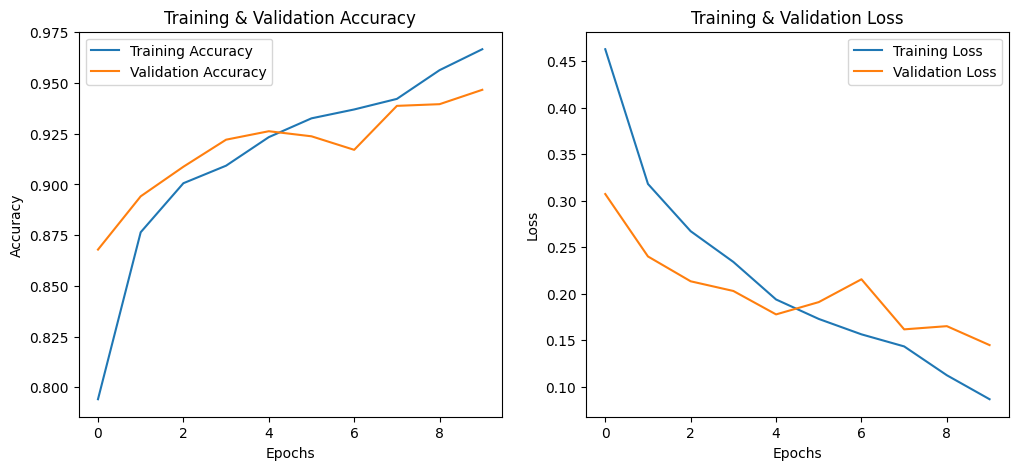

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Créer le modèle
model = create_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Générateurs de données pour l'entraînement et la validation
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)  # 20% pour validation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Ajouter Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

# Sauvegarder le modèle
model.save('lung_cancer_cnn_model.h5')

# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important pour bien aligner les prédictions avec les labels
)

# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

# Prédictions et vraies étiquettes
y_true = test_generator.classes  # Les vraies classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convertir les probabilités en classes

# Liste des noms de classes
class_names = list(test_generator.class_indices.keys())

# Rapport de classification
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualiser l'historique de l'entraînement
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define class labels (adjust based on your dataset)
class_labels =["lung_aca", "lung_n", "lung_scc"] # Update based on your classes

# Load the trained model
model = tf.keras.models.load_model('lung_cancer_cnn_model.h5')

# Load and preprocess the image
img_path = '/kaggle/working/test/lung_scc/lungscc1029.jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(128, 128))  # Match model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)  # Get class index

# Get class name
predicted_class_name = class_labels[predicted_class_index]

# Display result
print(f"Classe prédite : {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Classe prédite : lung_scc


ResNet

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [24]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze convolutional base to keep pretrained features
for layer in base_model_resnet.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
x_resnet = Flatten()(base_model_resnet.output)
x_resnet = Dense(512, activation='relu')(x_resnet)
x_resnet = Dropout(0.5)(x_resnet)
x_resnet = Dense(3, activation='softmax')(x_resnet)  # 3 classes

# Create the complete model
model_resnet = Model(inputs=base_model_resnet.input, outputs=x_resnet)


In [26]:
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [27]:
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation'
)


Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_resnet = model_resnet.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping_resnet])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.4606 - loss: 1.0647 - val_accuracy: 0.5196 - val_loss: 0.8816
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.6079 - loss: 0.8356 - val_accuracy: 0.5938 - val_loss: 0.8259
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.6535 - loss: 0.7686 - val_accuracy: 0.7079 - val_loss: 0.7309
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.6834 - loss: 0.7201 - val_accuracy: 0.7229 - val_loss: 0.6620
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.7080 - loss: 0.6803 - val_accuracy: 0.7362 - val_loss: 0.6281
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 122ms/step - accuracy: 0.7179 - loss: 0.6503 - val_accuracy: 0.7342 - val_loss: 0.6171
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.7305 - loss: 0.6323 - val_accuracy: 0.7583 - val_loss: 0.5913
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.7403 - loss: 0.5998 - val

In [29]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_generator)
print("ResNet50 Test Accuracy:", test_accuracy_resnet)


Found 3000 images belonging to 3 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.6347 - loss: 0.7235
ResNet50 Test Accuracy: 0.7573333382606506


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step

Classification Report:

              precision    recall  f1-score   support

    lung_aca       0.71      0.52      0.60      1000
      lung_n       0.77      0.91      0.83      1000
    lung_scc       0.78      0.85      0.81      1000

    accuracy                           0.76      3000
   macro avg       0.75      0.76      0.75      3000
weighted avg       0.75      0.76      0.75      3000



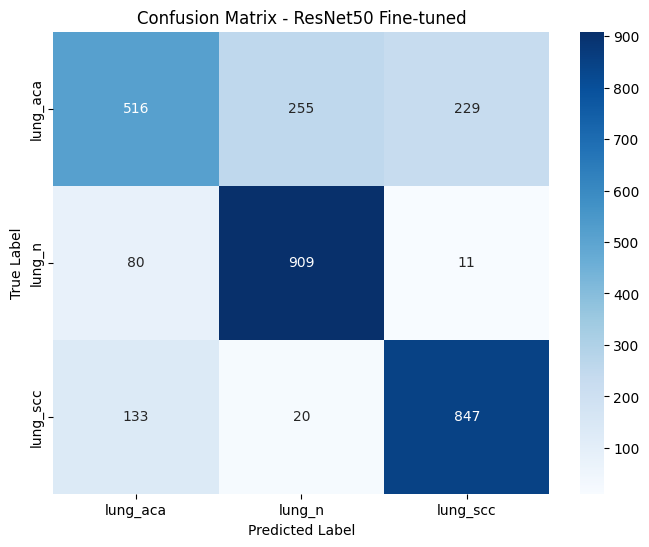

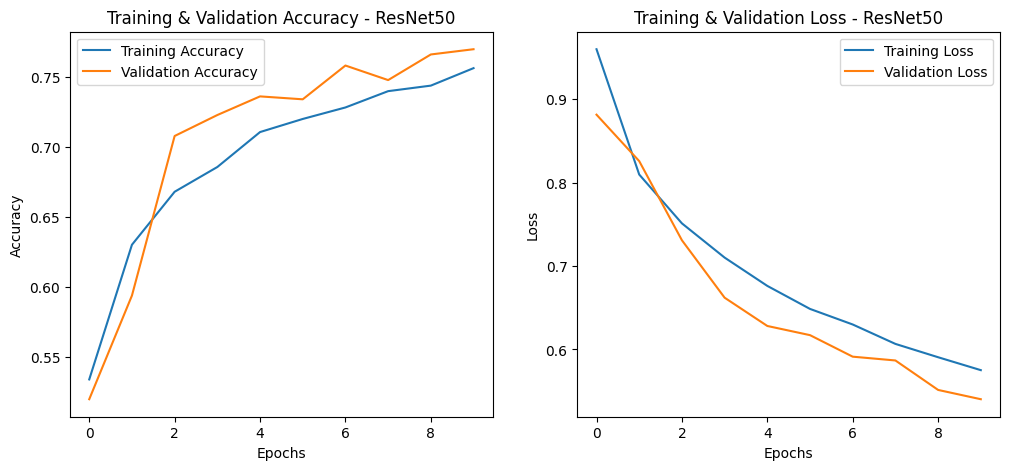

In [30]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Obtenir les vraies étiquettes et les prédictions
y_true = test_generator.classes

# Prédictions brutes (probabilités)
y_pred_prob = model_resnet.predict(test_generator)

# Convertir en labels prédits (classe ayant la probabilité max)
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtenir les noms des classes (même ordre que flow_from_directory)
class_names = list(test_generator.class_indices.keys())

# Afficher le rapport de classification
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet50 Fine-tuned')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualiser les courbes d'entraînement : précision et perte
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy - ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss - ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
print(f"Custom CNN Test Accuracy: {test_accuracy}")
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet}")


Custom CNN Test Accuracy: 0.9526666402816772
ResNet50 Test Accuracy: 0.7573333382606506


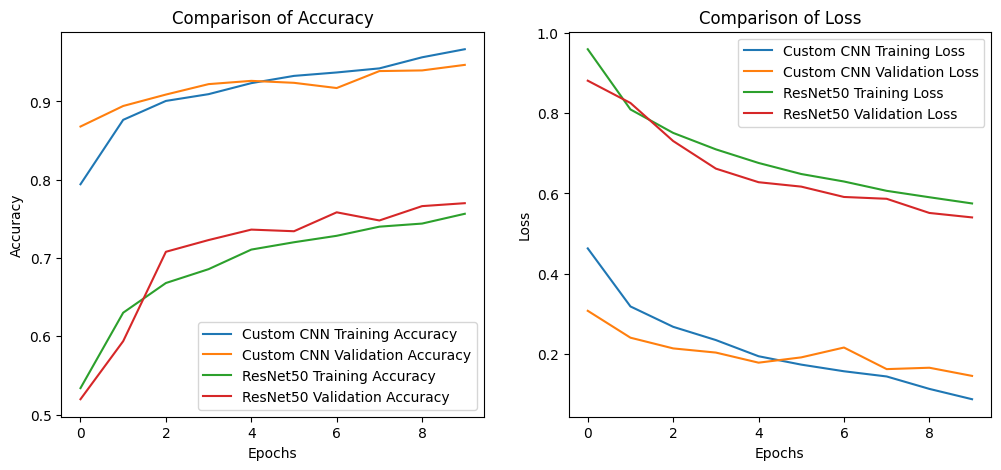

In [32]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Custom CNN Validation Accuracy')
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.title('Comparison of Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Custom CNN Training Loss')
plt.plot(history.history['val_loss'], label='Custom CNN Validation Loss')
plt.plot(history_resnet.history['loss'], label='ResNet50 Training Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Validation Loss')
plt.title('Comparison of Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [33]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
img_path = "/kaggle/working/test/lung_n/lungn1000.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict using ResNet50
prediction_resnet = model_resnet.predict(img_array)
predicted_class_resnet = np.argmax(prediction_resnet)
print("Predicted Class (ResNet50):", classes[predicted_class_resnet])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class (ResNet50): lung_n


**VGG**


In [34]:

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze convolutional base to keep pretrained features
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  # 3 classes

# Create new model
model_vgg16 = Model(inputs=base_model.input, outputs=x)


In [37]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [38]:
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation'
)


Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_vgg16 = model_vgg16.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.8478 - loss: 0.3585 - val_accuracy: 0.9529 - val_loss: 0.1289
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9490 - loss: 0.1370 - val_accuracy: 0.9563 - val_loss: 0.1181
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9614 - loss: 0.1060 - val_accuracy: 0.9617 - val_loss: 0.1012
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.9714 - loss: 0.0799 - val_accuracy: 0.9504 - val_loss: 0.1162
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9697 - loss: 0.0831 - val_accuracy: 0.9646 - val_loss: 0.0874
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9704 - loss: 0.0713 - val_accuracy: 0.9621 - val_loss: 0.0866
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 122ms/step - accuracy: 0.9768 - loss: 0.0601 - val_accuracy: 0.9679 - val_loss: 0.0758
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9816 - loss: 0.0497 - val

In [40]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator)
print("VGG16 Test Accuracy:", test_accuracy_vgg16)


Found 3000 images belonging to 3 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9634 - loss: 0.0960
VGG16 Test Accuracy: 0.9729999899864197


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step

Classification Report - VGG16 :

              precision    recall  f1-score   support

    lung_aca       0.97      0.95      0.96      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.95      0.97      0.96      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



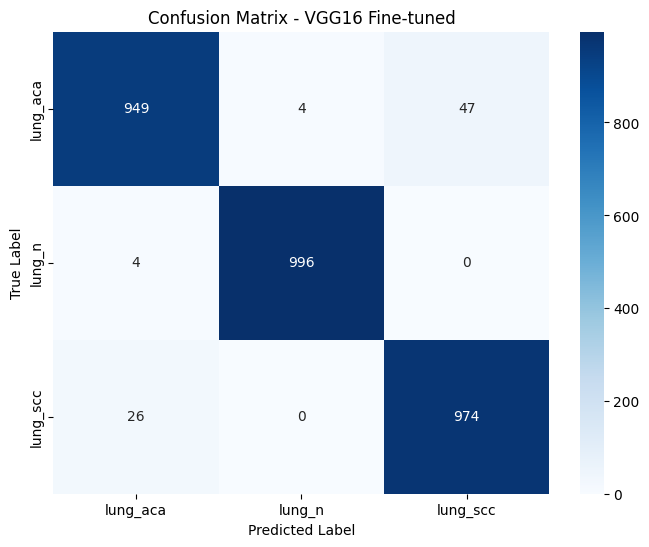

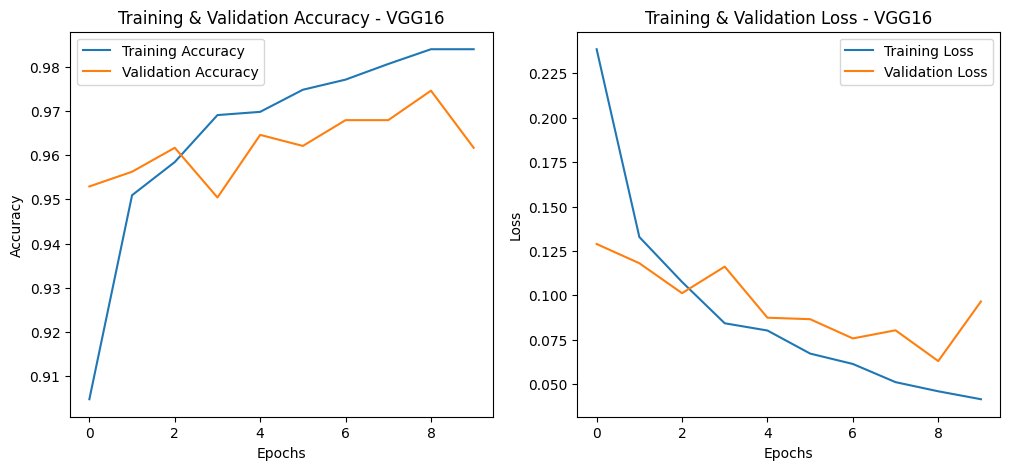

In [41]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Obtenir les vraies étiquettes et les prédictions
y_true_vgg = test_generator.classes

# Prédictions brutes (probabilités)
y_pred_prob_vgg = model_vgg16.predict(test_generator)

# Convertir en labels prédits (classe ayant la probabilité maximale)
y_pred_vgg = np.argmax(y_pred_prob_vgg, axis=1)

# Obtenir les noms des classes (dans le même ordre que flow_from_directory)
class_names = list(test_generator.class_indices.keys())

# Afficher le rapport de classification
print("\nClassification Report - VGG16 :\n")
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_names))

# Afficher la matrice de confusion
conf_matrix_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - VGG16 Fine-tuned')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualisation des courbes d'entraînement (précision & perte)
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
print(f"Custom CNN Test Accuracy: {test_accuracy}")
print(f"VGG16 Test Accuracy: {test_accuracy_vgg16}")


Custom CNN Test Accuracy: 0.9526666402816772
VGG16 Test Accuracy: 0.9729999899864197


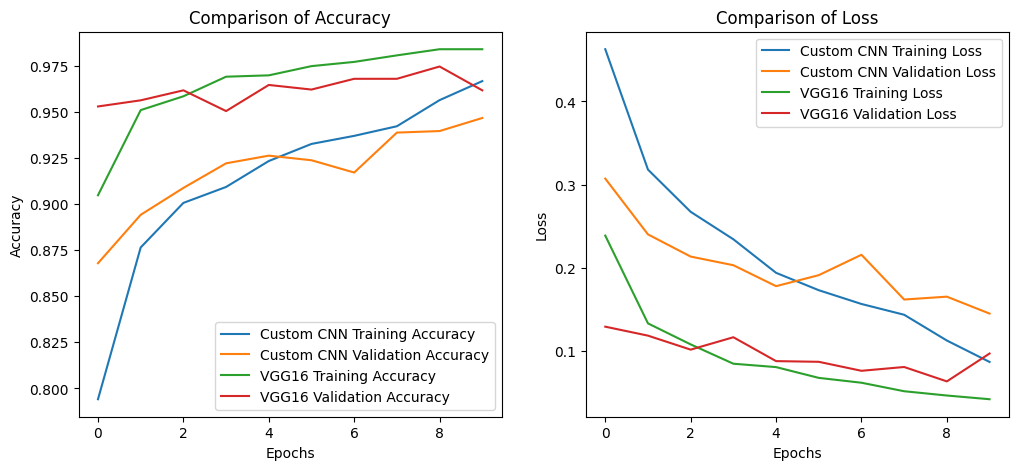

In [43]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Custom CNN Validation Accuracy')
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Comparison of Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Custom CNN Training Loss')
plt.plot(history.history['val_loss'], label='Custom CNN Validation Loss')
plt.plot(history_vgg16.history['loss'], label='VGG16 Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Comparison of Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [44]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
img_path = "/kaggle/working/test/lung_scc/lungscc1012.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict using VGG16
prediction = model_vgg16.predict(img_array)
predicted_class = np.argmax(prediction)
print("Predicted Class:", classes[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
Predicted Class: lung_scc


In [45]:
# Dégeler les dernières couches du modèle de base
for layer in base_model_resnet.layers[-20:]:  # Par exemple, on dégèle les 20 dernières couches
    layer.trainable = True

# Recompiler le modèle (avec un learning rate plus faible pour ne pas "casser" les poids pré-entraînés)
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continuer l’entraînement avec fine-tuning
history_finetune = model_resnet.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step - accuracy: 0.6987 - loss: 0.9471 - val_accuracy: 0.3346 - val_loss: 5.2158
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.8425 - loss: 0.3858 - val_accuracy: 0.8525 - val_loss: 0.3598
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.8714 - loss: 0.3157 - val_accuracy: 0.8229 - val_loss: 0.4189
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9001 - loss: 0.2534 - val_accuracy: 0.8771 - val_loss: 0.3162
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.9154 - loss: 0.2109 - val_accuracy: 0.8733 - val_loss: 0.3379


In [46]:
# 5. Fine-Tuning : Dégeler les dernières couches de VGG16 (par exemple, les 5 dernières)
for layer in base_model.layers[-5:]:
    layer.trainable = True

# 6. Recompiler avec un learning rate plus faible
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Ré-entraînement complet avec Fine-Tuning
fine_tune_history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.9826 - loss: 0.0629 - val_accuracy: 0.9500 - val_loss: 0.1418
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9818 - loss: 0.0527 - val_accuracy: 0.9500 - val_loss: 0.1441
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9832 - loss: 0.0511 - val_accuracy: 0.9508 - val_loss: 0.1449
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9845 - loss: 0.0470 - val_accuracy: 0.9504 - val_loss: 0.1455
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9839 - loss: 0.0462 - val_accuracy: 0.9508 - val_loss: 0.1462
